## Align a query dataset to Pan Fetal Immune data 

In this notebook, we use the scArches method to map query dataset to the scVI model trained on the pan-fetal dataset. Roughly following the [vignette](https://docs.scvi-tools.org/en/stable/user_guide/notebooks/scarches_scvi_tools.html#) in scvi-tools 

In [4]:
import sys,os
import scvi
import anndata
import matplotlib
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap


import numpy as np
import pandas as pd
import scanpy as sc
import numpy.random as random

In [5]:
sc.set_figure_params(figsize=(4, 4))
scvi.settings.seed = 94705

### Load pediatric gut data

In [7]:
!wget https://cellgeni.cog.sanger.ac.uk/gutcellatlas/pediatric_RAWCOUNTS_cellxgene.h5ad

--2021-07-13 09:42:33--  https://cellgeni.cog.sanger.ac.uk/gutcellatlas/pediatric_RAWCOUNTS_cellxgene.h5ad
Resolving cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)... 172.27.51.3, 172.27.51.1, 172.27.51.130, ...
Connecting to cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)|172.27.51.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344215080 (328M) [application/x-hdf]
Saving to: ‘pediatric_RAWCOUNTS_cellxgene.h5ad’

pediatric_RAWCOUNTS 100%[===================>] 328.27M  80.7MB/s    in 4.0s    

2021-07-13 09:42:37 (82.0 MB/s) - ‘pediatric_RAWCOUNTS_cellxgene.h5ad’ saved [344215080/344215080]



In [110]:
query_adata = sc.read_h5ad("pediatric_RAWCOUNTS_cellxgene.h5ad")

## subset healthy controls
query_adata = query_adata[query_adata.obs["Diagnosis"] == "Normal control"]

In [111]:
query_adata

View of AnnData object with n_obs × n_vars = 10411 × 33694
    obs: 'Age', 'Diagnosis', 'Sample name', 'Type', 'batch', 'doublet_scores', 'predicted_doublets', 'n_genes', 'percent_mito', 'n_counts', 'annotation_V2', 'inferred state'
    var: 'gene_ids'

### Map to pan fetal

In [221]:
scvi_outs_dir = "/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/"
model_dir = "scvi_HSC_IMMUNE_model_test/"

split="HSC_IMMUNE"
query_gene_id_col = "gene_ids"
batch_name = "gut_ped"

In [176]:
def _map_query_to_panfetal(
    query_adata,
    split,
    batch_name,
    scvi_outs_dir = "/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/",
    query_gene_id_col = "gene_ids",
    model_dir = None
    ):
    '''
    Use scArches method to do online update of scvi-tools model with query dataset
    
    Params:
    -------
    - query_adata: anndata object of query dataset to map
    - split: name of split to use (to chose the model)
    - batch_name: how do you want to label the new data you are adding
    - scvi_outs_dir: directory storing the scVI training outputs
    - query_gene_id_col: string indicating column in `query_adata.var` containing geneIDs 
    (used for feature matching if the saved features from trained model are not matched)
    - model_dir: which model directory in `scvi_outs` to use? (Default: None, uses `scvi_{split}_model_test/`)
    
    Outputs:
    - anndata with new embedding in obsm ("X_scVI_project")
    '''
    if model_dir is None:
        model_dir='scvi_' + split + '_model_test/'
    ## Check that the feature used for reference training match the var_names in query data
    var_names_model = pd.read_csv(scvi_outs_dir + model_dir + "var_names.csv", header=None)[0].values

    vars_overlap = any(pd.Series(var_names_model).isin(query_adata.var_names))

    ## Extract gene ids if not
    if not vars_overlap:
        adata_ref_var = pd.read_csv(scvi_outs_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.var.csv'.format(t=timestamp, s=split), index_col=0)
        adata_lognorm_var.iloc[var_names_model]['GeneID'].to_csv(scvi_outs_dir + model_dir + "var_names.csv", header=None, index=False)
        query_adata.var["gene_name"] = query_adata.var_names.copy()
        query_adata.var_names = query_adata.var[query_gene_id_col]

    ## Zero-fill missing genes in query
    is_in_query_var = pd.Series(var_names_model).isin(query_adata.var_names)
    n_genes = len(keep_genes[~is_in_query_var])
    if n_genes > 0:
        empty_X = np.zeros(shape=[ query_adata.n_obs, n_genes])
        empty_query_adata = anndata.AnnData(X=empty_X, obs=query_adata.obs)
        empty_query_adata.var_names = keep_genes[~is_in_query_var]
        empty_query_adata.var_names.names = ["gene_ids"]
        query_adata_filled = anndata.concat([query_adata, empty_query_adata], axis=1)
        query_adata_filled = query_adata_filled[:,keep_genes]
    else:
        query_adata_filled = query_adata.copy()

    ## Add batch column
    query_adata_filled.obs["bbk"] = batch_name

    ## Load new model with the query data
    vae_q = scvi.model.SCVI.load_query_data(
        query_adata_filled,
        scvi_outs_dir + model_dir,
        inplace_subset_query_vars=True
    )

    ## Train
    vae_q.train(max_epochs=200, plan_kwargs=dict(weight_decay=0.0))
    query_adata_filled.obsm["X_scVI_project"] = vae_q.get_latent_representation()
    return(query_adata_filled)

In [178]:
sc.pp.neighbors(query_adata_filled, use_rep="X_scVI_project")
sc.tl.leiden(query_adata_filled)
sc.tl.umap(query_adata_filled)

In [183]:
query_adata_filled.obs = pd.concat([query_adata_filled.obs, query_adata.obs], 1)

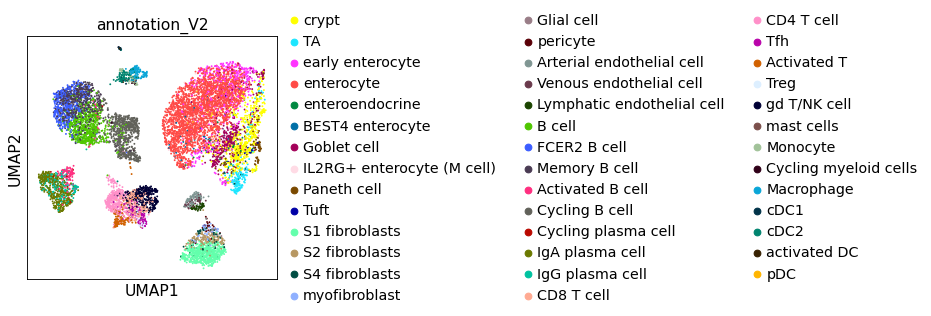

In [185]:
sc.pl.umap(
    query_adata_filled, 
    color="annotation_V2"
          )

In [192]:
query_adata

AnnData object with n_obs × n_vars = 10411 × 33694
    obs: 'Age', 'Diagnosis', 'Sample name', 'Type', 'batch', 'doublet_scores', 'predicted_doublets', 'n_genes', 'percent_mito', 'n_counts', 'annotation_V2', 'inferred state'
    var: 'gene_ids', 'gene_name'